<AxesSubplot:>

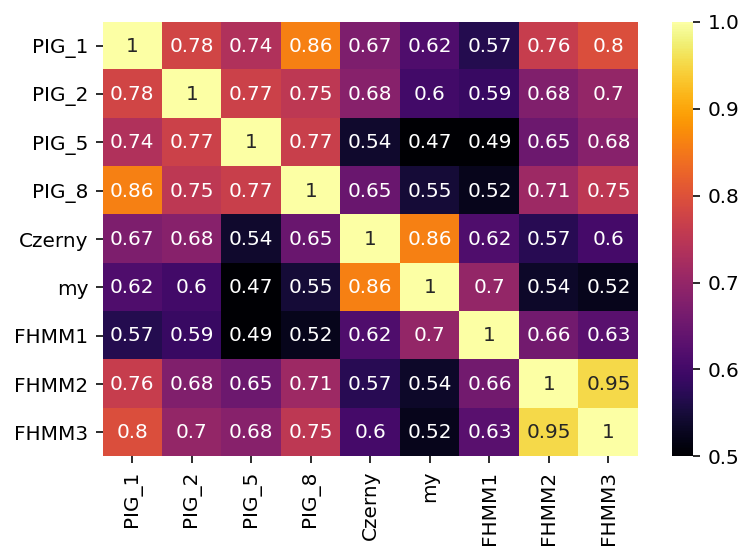

In [45]:
def make_match_matrix(pig_array, ch):
    pig_fingers = [table[table.ch == ch].finger for table in pig_array]
    data_length = len(pig_fingers[0])
    arr = np.zeros(shape = (len(pig_array), len(pig_array)))
    for i, j in itertools.product(range(len(pig_fingers)), range(len(pig_fingers))):
        fingerPair = zip(pig_fingers[i], pig_fingers[j]) # make pair
        cnt = 0
        for _, fs in enumerate(fingerPair):
            if len(set(fs)) < len(fs):
                cnt += 1
        arr[i, j] = cnt / data_length
    df = pd.DataFrame(arr)
    df.columns = titles
    df.index = titles
    return df

df = make_match_matrix(tables, 0)
sns.heatmap(df, cmap=plt.get_cmap("inferno"), vmin = 0.5, vmax = 1.0, annot=True)

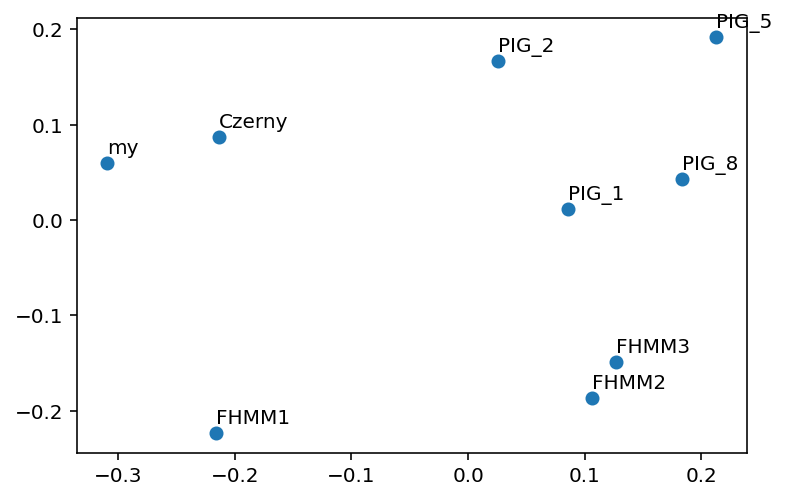

In [102]:
from sklearn import manifold
mds = manifold.MDS(n_components=2, dissimilarity="precomputed", random_state = 1)

df = 1 - make_match_matrix(tables, 0)
pos = mds.fit_transform(df)

plt.scatter(pos[:, 0], pos[:, 1], marker = 'o')
for i, xy in enumerate(zip(pos[:, 0], pos[:, 1])):
    plt.text(xy[0], xy[1] + 0.01, df.columns[i])

        L 5th  L 4th  L 3rd  L 2nd  L 1st  R 1st  R 2nd  R 3rd  R 4th  R 5th
PIG_1    32.0   42.0   59.0   51.0   35.0   39.0   69.0   66.0   54.0   22.0
PIG_2    32.0   35.0   53.0   56.0   43.0   44.0   68.0   64.0   50.0   24.0
PIG_5    28.0   38.0   54.0   60.0   39.0   44.0   68.0   64.0   49.0   25.0
PIG_8    20.0   37.0   55.0   61.0   46.0   38.0   67.0   70.0   50.0   25.0
Czerny   20.0   31.0   55.0   62.0   51.0   50.0   72.0   67.0   44.0   17.0
my       11.0   38.0   56.0   68.0   46.0   50.0   65.0   68.0   51.0   16.0
FHMM1    17.0   22.0   43.0   75.0   62.0   43.0   74.0   74.0   44.0   15.0
FHMM2    20.0   26.0   49.0   68.0   56.0   51.0   72.0   62.0   48.0   17.0
FHMM3    19.0   29.0   49.0   67.0   55.0   49.0   74.0   61.0   46.0   20.0
xi2 = 66.78495702296472


<AxesSubplot:>

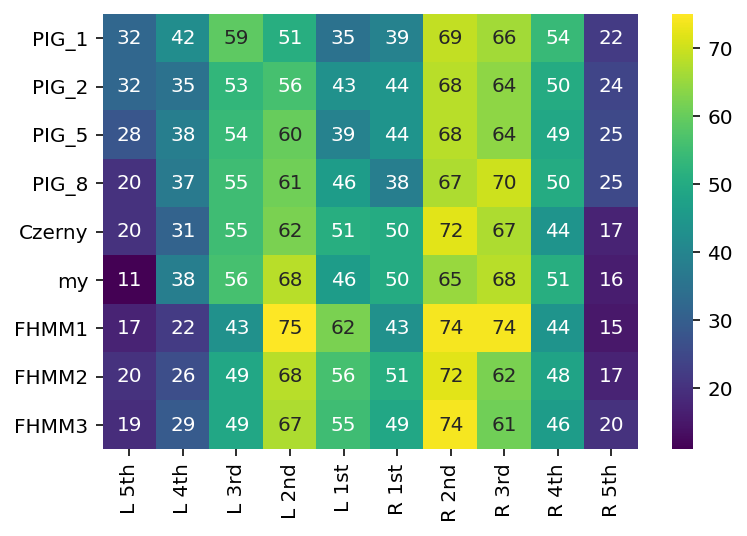

In [46]:
def make_finger_matrix_both_hands(pig_array):
    pig_fingers = [table for table in pig_array]
    arr = np.zeros(shape = (len(pig_fingers), 10))
    for i in range(len(pig_fingers)):
        lefts = pig_fingers[i][pig_fingers[i].ch == 1].finger
        rights = pig_fingers[i][pig_fingers[i].ch == 0].finger
        for j in range(0, 5):
            arr[i, j] = len(lefts[lefts == 5 - j])
        for j in range(5, 10):
            arr[i, j] = len(rights[rights == (j - 5 + 1)])
    df = pd.DataFrame(arr, columns = ["L 5th", "L 4th", "L 3rd", "L 2nd", "L 1st", "R 1st", "R 2nd", "R 3rd", "R 4th", "R 5th"])
    return df

df = make_finger_matrix_both_hands(tables)
df.index = titles
print(df)

expect = df.sum() / len(tables)
df_e = df - expect
df_xi = (df_e * df_e / expect)
xi = df_xi.sum().sum()
print(f"xi2 = {xi}")

sns.heatmap(df, annot=True, cmap = "viridis")

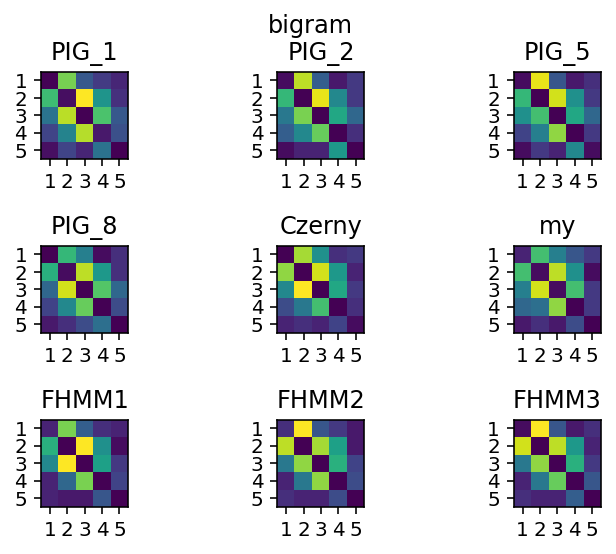

In [114]:
def make_finger_transition_table(pig, ch):
    fingers = pig[pig.ch == ch].finger
    a = np.ndarray(shape = (5, 5), dtype = float)
    for i, z in enumerate(zip(fingers.shift(1), fingers)):
        if i == 0:
            continue
        a[int(z[0]) - 1, int(z[1]) - 1] += 1
    return a

fig, ax = plt.subplots(3, 3)
fig.subplots_adjust(hspace = 1)
fig.suptitle("bigram")
for i in range(len(tables)):
    df = make_finger_transition_table(tables[i], 0)
    a = ax[int(i / 3), int(i % 3)]
    a.set_title(titles[i])
    a.set_xticks(range(5))
    a.set_yticks(range(5))
    a.set_xticklabels([i + 1 for i in range(5)])
    a.set_yticklabels([i + 1 for i in range(5)])
    img = a.imshow(df, cmap=plt.get_cmap("viridis"), vmin = 0, vmax = 30)
#fig.colorbar(img)

In [48]:
actions = np.zeros(shape = (len(tables), 4))
ch = 0
for p, table in enumerate(tables):
    notes = table[table.ch == ch]
    tds = notes.t0.shift(-1) - notes.t1
    pds = notes.pos.shift(-1) - notes.pos
    fds = notes.finger.shift(-1) - notes.finger
    for i in range(len(notes)):
        n = notes.iloc[i]
        pd_ = pds.iloc[i]
        fd_ = fds.iloc[i]
        if tds.iloc[i] < 1 / 32: # 休符を挟まない
            # 鍵盤上の距離より、指番号の差の方が大きい＝指寄せ
            if len(n.fingers) > 1 or np.sign(pd_) == np.sign(fd_) and abs(pd_) < abs(fd_) - 0.5:
                actions[p, 0] += 1
            # 鍵盤上の距離より、指番号の差の方が小さい
            elif np.sign(pd_) == np.sign(fd_) and abs(pd_) > abs(fd_) + 0.5:
                actions[p, 1] += 1
            # 指くぐり、指超え
            elif np.sign(pd_) != np.sign(fd_):
                if np.sign(pd_) >= 0 and abs(n.finger == 1):
                    actions[p, 2] += 1
                else:
                    actions[p, 3] += 1

dfa = pd.DataFrame(actions, columns = ["寄せ", "跳躍", "潜り", "超え"], index = titles)
dfa

,寄せ,跳躍,潜り,超え
PIG_1,5.0,23.0,0.0,15.0
PIG_2,7.0,22.0,1.0,14.0
PIG_5,7.0,24.0,0.0,20.0
PIG_8,8.0,24.0,0.0,14.0
Czerny,11.0,22.0,2.0,11.0
my,10.0,19.0,1.0,13.0
FHMM1,2.0,42.0,1.0,9.0
FHMM2,3.0,32.0,2.0,10.0
FHMM3,2.0,31.0,3.0,12.0


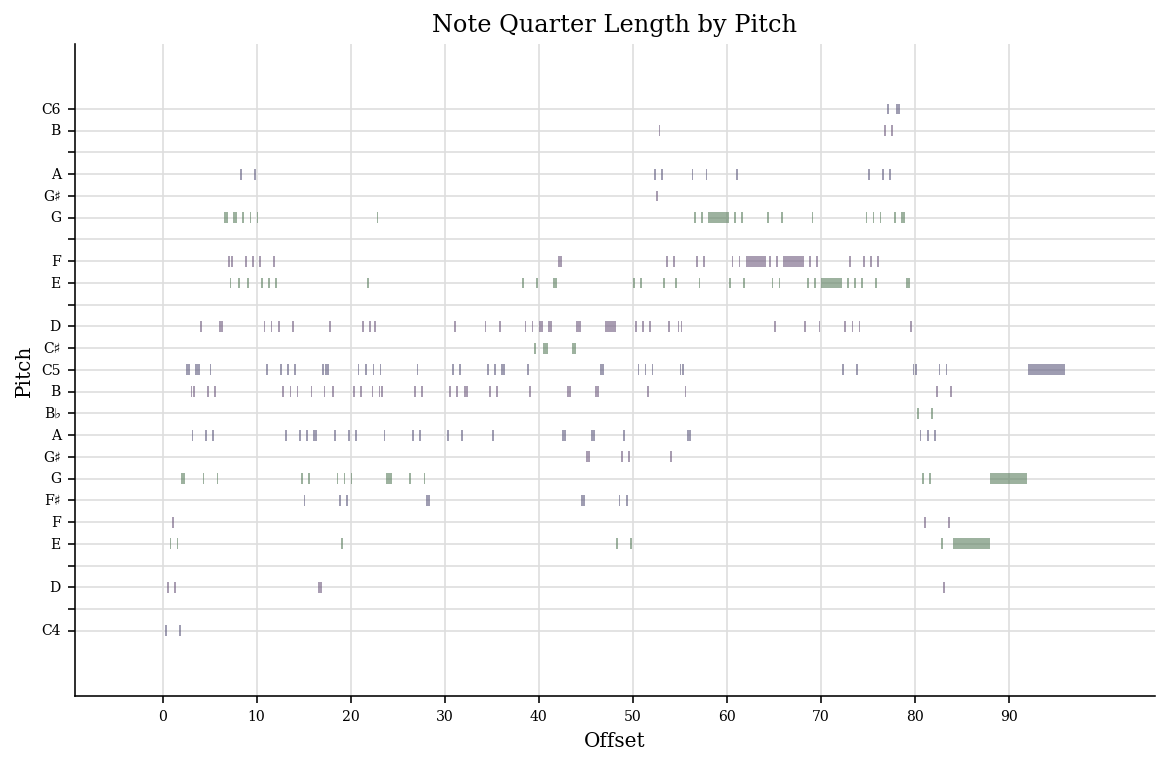

In [32]:
# https://miso-soup3.hateblo.jp/entry/2018/12/20/223705
table = tables[0]
score = makeScore(table)
score.parts[0].plot()

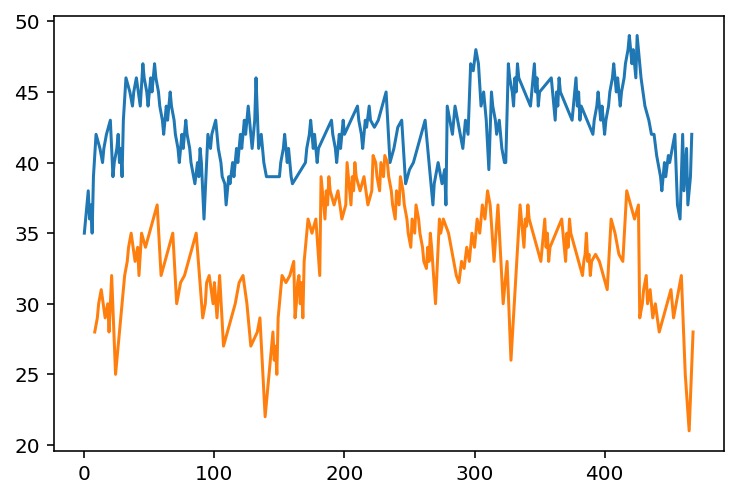

In [63]:
plt.plot(table[table.ch == 0].pos)
plt.plot(table[table.ch == 1].pos)

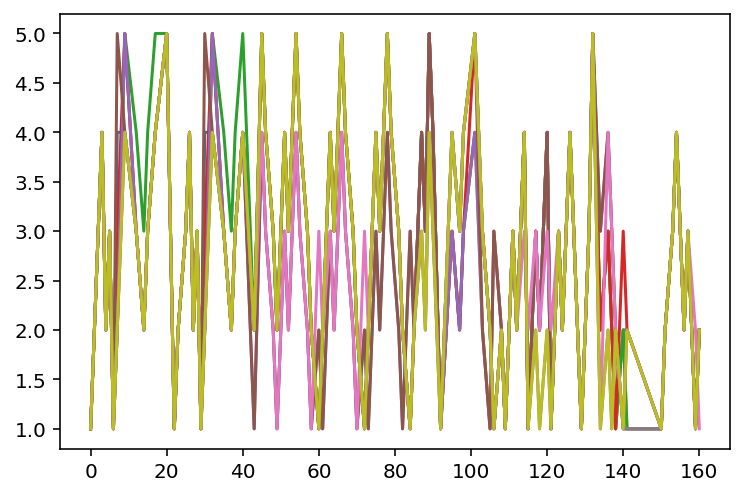

In [5]:
ch = 0
for p, table in enumerate(tables):
    notes = table[table.ch == ch]
    plt.plot(notes.finger[0:100])